In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import cv2
import os
import time

print(tf.__version__)
from tensorflow.keras import optimizers, metrics, losses
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K
from keras.initializers import RandomNormal

from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout, ZeroPadding2D, UpSampling2D
from tensorflow.keras.layers import Conv1D,MaxPooling1D,Conv1DTranspose,AveragePooling1D,GlobalMaxPool1D,GlobalAveragePooling1D
from tensorflow.keras.layers import Conv2D,MaxPool2D,Conv2DTranspose,AveragePooling2D,GlobalMaxPool2D,GlobalAveragePooling2D
from tensorflow.keras.layers import Conv3D,MaxPooling3D,Conv3DTranspose,AveragePooling3D,GlobalMaxPool3D,GlobalAveragePooling3D
from tensorflow.keras.layers import Dense,Flatten,Dropout,Concatenate,Layer,BatchNormalization,Input,Add,Activation,Average

from tensorflow.keras import layers
import tensorflow as tf


2024-11-15 01:37:39.720593: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9373] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-15 01:37:39.720673: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-15 01:37:39.722998: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1534] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.15.0


In [2]:
#data_path = "outlineOutput"
#data_path = "H:\\download\\blender\\projects\\vdmTests\\outlineOutput"
#output_path = "H:\\tmp\\dexined"

data_path = "/media/Tomasz/4T/work/tmp/tinyDexinedDataset2"
output_path = "/media/Tomasz/4T/work/tmp/teed"

train_path = data_path + "/train/*"
edge_train_path = data_path + "/train_edge/*"

test_path = data_path + "/test/*"
edge_test_path = data_path + "/test_edge/*"

val_path = data_path + "/val/*"
edge_val_path = data_path + "/val_edge/*"

print(edge_test_path)

def load_data(ipath, epath):
    images = sorted(glob(os.path.join(ipath)))
    edges = sorted(glob(os.path.join(epath)))
    return images, edges

images, edges = load_data(train_path, edge_train_path)
valimg, valedg = load_data(val_path, edge_val_path)
print(len(images), len(valimg))

def read_image(path, H=16, W=16):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W,H))
    x = x/255.0
    x = x.astype(np.float32)
    return x

def read_edge(path, H=16, W=16):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (W,H))
    x = np.expand_dims(x, axis=-1)
    x = x/255.0
    x = x.astype(np.float32)
    return x

def preprocess(x,y,H=16, W=16):

    def f(x,y):
        x = x.decode()
        y = y.decode()

        x = read_image(x)
        y = read_edge(y)
        return x, y

    images, edges = tf.numpy_function(f, [x, y], [tf.float32, tf.float32])
    images.set_shape([H, W, 3])
    edges.set_shape([H, W, 1])
    return images, edges

def tf_data(x,y,bs):
    data = tf.data.Dataset.from_tensor_slices((x,y))
    data = data.shuffle(buffer_size=bs)
    data = data.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    data = data.batch(2)
    data = data.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return data

train_data = tf_data(images, edges, len(images))
val_data = tf_data(valimg, valedg, len(valimg))

print(len(train_data),len(val_data))

/media/Tomasz/4T/work/tmp/tinyDexinedDataset2/test_edge/*
4 2


2024-11-15 01:37:47.084128: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:00:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-15 01:37:47.097647: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:00:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-15 01:37:47.097891: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:00:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-15 01:37:47.100504: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:00:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-15 01:37:47.100728: I external/local_xla/xla/stream_executor

2 1


/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:00:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-15 01:37:47.198146: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:00:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-15 01:37:47.198404: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:00:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-15 01:37:47.198463: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2019] Could not identify NUMA node of platform GPU id 0, defaulting to 0.  Your kernel may not have been built with NUMA support.
2024-11-15 01:37:47.198571: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000

In [3]:

def train(model,model_name,train_data,test_data,lr,beta1,max_epochs,batch_size):
    # Validation and Train dataset generation

    train_data = train_data
    n_train =len(train_data) #data_cache["n_files"]
    val_data = test_data
    
    # Summary and checkpoint manager
    model_dir = model_name
    summary_dir = os.path.join(output_path,'logs',model_dir)
    train_log_dir=os.path.join(summary_dir,'train')
    val_log_dir =os.path.join(summary_dir,'test')

    checkpoint_dir = os.path.join(output_path,"checkpoint_dir",model_dir)
    epoch_ckpt_dir = checkpoint_dir + 'epochs'
    os.makedirs(epoch_ckpt_dir, exist_ok=True)
    os.makedirs(train_log_dir,exist_ok=True)
    os.makedirs(val_log_dir,exist_ok=True)
    os.makedirs(checkpoint_dir, exist_ok=True)

    train_writer = tf.summary.create_file_writer(train_log_dir)
    val_writer = tf.summary.create_file_writer(val_log_dir)

    my_model = model

    # accuracy = metrics.SparseCategoricalAccuracy()
    accuracy = metrics.BinaryAccuracy()
    accuracy_val = metrics.BinaryAccuracy()
    loss_bc = losses.BinaryCrossentropy()
    optimizer = optimizers.Adam(
        learning_rate=lr, beta_1=beta1)
    iter = 0

    imgs_res_folder = os.path.join(output_path,model_dir, "current_training")
    os.makedirs(imgs_res_folder, exist_ok=True)
    global_loss = 1000.
    t_loss = []
    ckpt_save_mode = "h5"
    tmp_lr = lr
    for epoch in range(max_epochs):
        # training
        t_loss = []
        # if epoch in self.args.adjust_lr:
        tmp_lr=tmp_lr*0.1
        optimizer.lr.assign(tmp_lr)
        for step, (x, y) in enumerate(train_data):

            with tf.GradientTape() as tape:
                pred = my_model(x, training=True)

                preds, loss = pre_process_binary_cross_entropy(
                    loss_bc, pred, y, use_tf_loss=False)

            accuracy.update_state(y_true=y, y_pred=preds[-1])
            gradients = tape.gradient(loss, my_model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, my_model.trainable_variables))

            # logging the current accuracy value so far.
            t_loss.append(loss.numpy())
            if step % 10 == 0:
                print("Epoch:", epoch, "Step:", step, "Loss: %.4f" % loss.numpy(),
                        "Accuracy: %.4f" % accuracy.result(), time.ctime())

            #if step % 10 == 0:
            #    # visualize preds
            #    img_test = 'Epoch: {0} Sample {1}/{2} Loss: {3}' \
            #        .format(epoch, step, n_train // batch_size, loss.numpy())
            #    vis_imgs = visualize_result(
            #        x=x[2], y=y[2], p=preds, img_title=img_test)
            #    cv.imwrite(os.path.join(imgs_res_folder, 'results.png'), vis_imgs)
            if step % 20 == 0 and loss < global_loss:  # 500
                if epoch==0 and step==0:
                    tmp_loss = np.array(t_loss)
                    with train_writer.as_default():
                        tf.summary.scalar('loss', tmp_loss.mean(), step=epoch)
                        tf.summary.scalar('accuracy', accuracy.result(), step=epoch)

                save_ckpt_path = os.path.join(checkpoint_dir, "DexiNedL_model.h5")
                Model.save_weights(my_model, save_ckpt_path, save_format='h5')

                global_loss = loss
                print("Model saved in:  ", save_ckpt_path, "Current loss:", global_loss.numpy())

            iter += 1  # global iteration

        t_loss = np.array(t_loss)
        # train summary
        if epoch!=0:
            with train_writer.as_default():
                tf.summary.scalar('loss', t_loss.mean(), step=epoch)
                tf.summary.scalar('accuracy', accuracy.result(), step=epoch)

        Model.save_weights(my_model, os.path.join(epoch_ckpt_dir, "DexiNed{}_model.h5".format(str(epoch))),
                            save_format=ckpt_save_mode)
        print("Epoch:", epoch, "Model saved in Loss: ", t_loss.mean())

        # validation
        t_val_loss = []
        for i, (x_val, y_val) in enumerate(val_data):

            pred_val = my_model(x_val)
            v_logits, V_loss = pre_process_binary_cross_entropy(
                loss_bc, pred_val, y_val, use_tf_loss=False)
            accuracy_val.update_state(y_true=y_val, y_pred=v_logits[-1])
            t_val_loss.append(V_loss.numpy())
            if i == 7:
                break
        val_acc = accuracy_val.result()
        t_val_loss = np.array(t_val_loss)
        print("Epoch(validation):", epoch, "Val loss: ", t_val_loss.mean(),
                "Accuracy: ", val_acc.numpy())
        # validation summary
        with val_writer.as_default():
            tf.summary.scalar('loss', t_val_loss.mean(), step=epoch)
            tf.summary.scalar('accuracy', val_acc.numpy(), step=epoch)

        # Reset metrics every epoch
        accuracy.reset_states()
        accuracy_val.reset_states()

    #my_model.summary()


In [4]:

weight_init = tf.initializers.glorot_uniform()

l2 = regularizers.l2
w_decay=1e-3

glorot_normal = RandomNormal(stddev=0.01)

orthogonal = tf.keras.initializers.Orthogonal(
    gain=1.0, seed=None
)

self_conv2D_3 = Conv2D(32 , kernel_size=(3,3),strides=(2,2),padding = 'same',use_bias=True,kernel_initializer= glorot_normal)
self_batchnormalization_24 = BatchNormalization()
self_conv2D_40 = Conv2D(64 , kernel_size=(3,3),strides=(1,1),padding = 'same',use_bias=True,kernel_initializer= glorot_normal)
self_batchnormalization_18 = BatchNormalization()
self_activation_11 = Activation(activation='relu')
self_conv2D_1 = Conv2D(128 , kernel_size=(3,3),strides=(1,1),padding = 'same')
self_conv2D_16 = Conv2D(128 , kernel_size=(1,1),strides=(2,2),padding = 'same',use_bias=True)
self_conv2D_51 = Conv2D(1 , kernel_size=(1,1),strides=(1,1),padding = 'same',use_bias=True)
self_batchnormalization_1 = BatchNormalization()
self_transpoze2D_9 = Conv2DTranspose(1 , kernel_size=(2,2),strides=(2,2),padding = 'same')
self_conv2D_49 = Conv2D(128 , kernel_size=(3,3),strides=(1,1),padding = 'same',use_bias=True)
self_batchnormalization_8 = BatchNormalization()
self_activation_1 = Activation(activation='relu')
self_conv2D_17 = Conv2D(1 , kernel_size=(1,1),strides=(1,1),padding = 'same',use_bias=True)
self_maxpool2D_1 = MaxPool2D(pool_size=(3,3),strides=(2,2),padding = 'same')
self_transpoze2D_10 = Conv2DTranspose(1 , kernel_size=(2,2),strides=(2,2),padding = 'same')
self_conv2D_28 = Conv2D(256 , kernel_size=(1,1),strides=(1,1),padding = 'same',use_bias=True)
self_conv2D_36 = Conv2D(256 , kernel_size=(1,1),strides=(2,2),padding = 'same',use_bias=True)
self_activation_8 = Activation(activation='relu')
self_conv2D_47 = Conv2D(256 , kernel_size=(1,1),strides=(2,2),padding = 'same',use_bias=True)
self_conv2D_48 = Conv2D(512 , kernel_size=(1,1),strides=(2,2),padding = 'same')
self_conv2D_33 = Conv2D(256 , kernel_size=(3,3),strides=(1,1),padding = 'same',use_bias=True)
self_batchnormalization_6 = BatchNormalization()
self_activation_9 = Activation(activation='relu')
self_conv2D_31 = Conv2D(256 , kernel_size=(3,3),strides=(1,1),padding = 'same',use_bias=True)
self_batchnormalization_22 = BatchNormalization()
self_activation_6 = Activation(activation='relu')
self_conv2D_30 = Conv2D(256 , kernel_size=(3,3),strides=(1,1),padding = 'same',use_bias=True)
self_batchnormalization_4 = BatchNormalization()
self_activation_7 = Activation(activation='relu')
self_conv2D_18 = Conv2D(256 , kernel_size=(3,3),strides=(1,1),padding = 'same',use_bias=True)
self_batchnormalization_20 = BatchNormalization()
self_conv2D_38 = Conv2D(16 , kernel_size=(1,1),strides=(1,1),padding = 'same',use_bias=True)
self_maxpool2D_2 = MaxPool2D(pool_size=(3,3),strides=(2,2),padding = 'same')
self_transpoze2D_15 = Conv2DTranspose(16 , kernel_size=(4,4),strides=(2,2),padding = 'same')
self_conv2D_11 = Conv2D(1 , kernel_size=(1,1),strides=(1,1),padding = 'same',use_bias=True)
self_conv2D_34 = Conv2D(512 , kernel_size=(1,1),strides=(2,2),padding = 'same',use_bias=True)
self_conv2D_50 = Conv2D(512 , kernel_size=(1,1),strides=(1,1),padding = 'same',use_bias=True)
self_transpoze2D_2 = Conv2DTranspose(1 , kernel_size=(4,4),strides=(2,2),padding = 'same')
self_activation_10 = Activation(activation='relu')
self_conv2D_32 = Conv2D(512 , kernel_size=(3,3),strides=(1,1),padding = 'same',use_bias=True)
self_batchnormalization_10 = BatchNormalization()
self_activation_5 = Activation(activation='relu')
self_conv2D_27 = Conv2D(512 , kernel_size=(3,3),strides=(1,1),padding = 'same',use_bias=True)
self_batchnormalization_19 = BatchNormalization()
self_activation_24 = Activation(activation='relu')
self_conv2D_26 = Conv2D(512 , kernel_size=(3,3),strides=(1,1),padding = 'same',use_bias=True)
self_batchnormalization_13 = BatchNormalization()
self_activation_16 = Activation(activation='relu')
self_conv2D_13 = Conv2D(512 , kernel_size=(3,3),strides=(1,1),padding = 'same',use_bias=True)
self_batchnormalization_17 = BatchNormalization()
self_activation_22 = Activation(activation='relu')
self_conv2D_29 = Conv2D(512 , kernel_size=(3,3),strides=(1,1),padding = 'same',use_bias=True)
self_batchnormalization_15 = BatchNormalization()
self_activation_23 = Activation(activation='relu')
self_conv2D_24 = Conv2D(512 , kernel_size=(3,3),strides=(1,1),padding = 'same',use_bias=True)
self_batchnormalization_12 = BatchNormalization()
self_conv2D_44 = Conv2D(16 , kernel_size=(1,1),strides=(1,1),padding = 'same',use_bias=True)
self_maxpool2D_3 = MaxPool2D(pool_size=(3,3),strides=(2,2),padding = 'same')
self_transpoze2D_7 = Conv2DTranspose(16 , kernel_size=(8,8),strides=(2,2),padding = 'same')
self_conv2D_45 = Conv2D(16 , kernel_size=(1,1),strides=(1,1),padding = 'same',use_bias=True)
self_activation_15 = Activation(activation='relu')
self_conv2D_6 = Conv2D(512 , kernel_size=(1,1),strides=(1,1),padding = 'same',use_bias=True)
self_conv2D_2 = Conv2D(512 , kernel_size=(1,1),strides=(1,1),padding = 'same',use_bias=True)
self_transpoze2D_8 = Conv2DTranspose(16 , kernel_size=(8,8),strides=(2,2),padding = 'same')
self_conv2D_43 = Conv2D(512 , kernel_size=(3,3),strides=(1,1),padding = 'same',use_bias=True)
self_conv2D_41 = Conv2D(1 , kernel_size=(1,1),strides=(1,1),padding = 'same',use_bias=True)
self_batchnormalization_7 = BatchNormalization()
self_transpoze2D_14 = Conv2DTranspose(1 , kernel_size=(8,8),strides=(2,2),padding = 'same')
self_activation_17 = Activation(activation='relu')
self_conv2D_19 = Conv2D(512 , kernel_size=(3,3),strides=(1,1),padding = 'same',use_bias=True)
self_batchnormalization_16 = BatchNormalization()
self_activation_13 = Activation(activation='relu')
self_conv2D_21 = Conv2D(512 , kernel_size=(3,3),strides=(1,1),padding = 'same',use_bias=True)
self_batchnormalization_14 = BatchNormalization()
self_activation_14 = Activation(activation='relu')
self_conv2D_15 = Conv2D(512 , kernel_size=(3,3),strides=(1,1),padding = 'same',use_bias=True)
self_batchnormalization_5 = BatchNormalization()
self_activation_18 = Activation(activation='relu')
self_conv2D_14 = Conv2D(512 , kernel_size=(3,3),strides=(1,1),padding = 'same',use_bias=True)
self_batchnormalization_26 = BatchNormalization()
self_activation_19 = Activation(activation='relu')
self_conv2D_5 = Conv2D(512 , kernel_size=(3,3),strides=(1,1),padding = 'same',use_bias=True)
self_batchnormalization_3 = BatchNormalization()
self_conv2D_8 = Conv2D(256 , kernel_size=(1,1),strides=(1,1),padding = 'same',use_bias=True)
self_conv2D_35 = Conv2D(16 , kernel_size=(1,1),strides=(1,1),padding = 'same',use_bias=True)
self_activation_20 = Activation(activation='relu')
self_transpoze2D_4 = Conv2DTranspose(16 , kernel_size=(16,16),strides=(2,2),padding = 'same')
self_conv2D_22 = Conv2D(256 , kernel_size=(3,3),strides=(1,1),padding = 'same',use_bias=True)
self_conv2D_12 = Conv2D(16 , kernel_size=(1,1),strides=(1,1),padding = 'same',use_bias=True)
self_batchnormalization_11 = BatchNormalization()
self_transpoze2D_12 = Conv2DTranspose(16 , kernel_size=(16,16),strides=(2,2),padding = 'same')
self_activation_21 = Activation(activation='relu')
self_conv2D_37 = Conv2D(16 , kernel_size=(1,1),strides=(1,1),padding = 'same',use_bias=True)
self_conv2D_10 = Conv2D(256 , kernel_size=(3,3),strides=(1,1),padding = 'same',use_bias=True)
self_transpoze2D_5 = Conv2DTranspose(16 , kernel_size=(16,16),strides=(2,2),padding = 'same')
self_batchnormalization_21 = BatchNormalization()
self_conv2D_42 = Conv2D(16 , kernel_size=(1,1),strides=(1,1),padding = 'same',use_bias=True)
self_transpoze2D_13 = Conv2DTranspose(1 , kernel_size=(16,16),strides=(2,2),padding = 'same')
self_activation_3 = Activation(activation='relu')
self_conv2D_20 = Conv2D(256 , kernel_size=(3,3),strides=(1,1),padding = 'same',use_bias=True)
self_batchnormalization_9 = BatchNormalization()
self_activation_4 = Activation(activation='relu')
self_conv2D_23 = Conv2D(256 , kernel_size=(3,3),strides=(1,1),padding = 'same',use_bias=True)
self_batchnormalization_2 = BatchNormalization()
self_activation_2 = Activation(activation='relu')
self_conv2D_7 = Conv2D(256 , kernel_size=(3,3),strides=(1,1),padding = 'same',use_bias=True)
self_batchnormalization_23 = BatchNormalization()
self_activation_12 = Activation(activation='relu')
self_conv2D_25 = Conv2D(256 , kernel_size=(3,3),strides=(1,1),padding = 'same',use_bias=True)
self_batchnormalization_25 = BatchNormalization()
self_conv2D_39 = Conv2D(16 , kernel_size=(1,1),strides=(1,1),padding = 'same',use_bias=True)
self_transpoze2D_11 = Conv2DTranspose(16 , kernel_size=(16,16),strides=(2,2),padding = 'same')
self_conv2D_4 = Conv2D(16 , kernel_size=(1,1),strides=(1,1),padding = 'same',use_bias=True)
self_transpoze2D_3 = Conv2DTranspose(16 , kernel_size=(16,16),strides=(2,2),padding = 'same')
self_conv2D_9 = Conv2D(16 , kernel_size=(1,1),strides=(1,1),padding = 'same',use_bias=True)
self_transpoze2D_6 = Conv2DTranspose(16 , kernel_size=(16,16),strides=(2,2),padding = 'same')
self_conv2D_46 = Conv2D(1 , kernel_size=(1,1),strides=(1,1),padding = 'same',use_bias=True)
self_transpoze2D_1 = Conv2DTranspose(1 , kernel_size=(16,16),strides=(2,2),padding = 'same')
#self_block_cat = SingleConvBlock(
#    1,k_size=(1,1),stride=(1,1),
#    w_init=tf.constant_initializer(1/5))

self_last_conv = Conv2D(1, kernel_size=(1,1), strides=(1,1), padding = 'same', kernel_initializer=tf.constant_initializer(1/5))
self_last_batchnormalization = BatchNormalization()
self_last_activation = Activation(activation='relu')

#-------------------------------------

x = Input(shape=(16,16,3))
conv2D_3 = self_conv2D_3(x)
batchnormalization_24 = self_batchnormalization_24(conv2D_3)
conv2D_40 = self_conv2D_40(batchnormalization_24)
batchnormalization_18 = self_batchnormalization_18(conv2D_40)
activation_11 = self_activation_11(batchnormalization_18)
conv2D_1 = self_conv2D_1(activation_11)
conv2D_16 = self_conv2D_16(activation_11)
conv2D_51 = self_conv2D_51(activation_11)
batchnormalization_1 = self_batchnormalization_1(conv2D_1)
transpoze2D_9 = self_transpoze2D_9(conv2D_51)
conv2D_49 = self_conv2D_49(batchnormalization_1)
batchnormalization_8 = self_batchnormalization_8(conv2D_49)
activation_1 = self_activation_1(batchnormalization_8)
conv2D_17 = self_conv2D_17(activation_1)
maxpool2D_1 = self_maxpool2D_1(activation_1)
transpoze2D_10 = self_transpoze2D_10(conv2D_17)
add_1 = Add()([conv2D_16,maxpool2D_1])
conv2D_28 = self_conv2D_28(maxpool2D_1)
conv2D_36 = self_conv2D_36(maxpool2D_1)
activation_8 = self_activation_8(add_1)
conv2D_47 = self_conv2D_47(add_1)
conv2D_48 = self_conv2D_48(conv2D_36)
conv2D_33 = self_conv2D_33(activation_8)
batchnormalization_6 = self_batchnormalization_6(conv2D_33)
activation_9 = self_activation_9(batchnormalization_6)
conv2D_31 = self_conv2D_31(activation_9)
batchnormalization_22 = self_batchnormalization_22(conv2D_31)
average_5 = Average()([batchnormalization_22,conv2D_28])
activation_6 = self_activation_6(average_5)
conv2D_30 = self_conv2D_30(activation_6)
batchnormalization_4 = self_batchnormalization_4(conv2D_30)
activation_7 = self_activation_7(batchnormalization_4)
conv2D_18 = self_conv2D_18(activation_7)
batchnormalization_20 = self_batchnormalization_20(conv2D_18)
average_4 = Average()([batchnormalization_20,conv2D_28])
conv2D_38 = self_conv2D_38(average_4)
maxpool2D_2 = self_maxpool2D_2(average_4)
transpoze2D_15 = self_transpoze2D_15(conv2D_38)
add_2 = Add()([conv2D_47,maxpool2D_2])
add_4 = Add()([conv2D_36,maxpool2D_2])
conv2D_11 = self_conv2D_11(transpoze2D_15)
conv2D_34 = self_conv2D_34(add_2)
conv2D_50 = self_conv2D_50(add_4)
transpoze2D_2 = self_transpoze2D_2(conv2D_11)
activation_10 = self_activation_10(add_2)
conv2D_32 = self_conv2D_32(activation_10)
batchnormalization_10 = self_batchnormalization_10(conv2D_32)
activation_5 = self_activation_5(batchnormalization_10)
conv2D_27 = self_conv2D_27(activation_5)
batchnormalization_19 = self_batchnormalization_19(conv2D_27)
average_3 = Average()([batchnormalization_19,conv2D_50])
activation_24 = self_activation_24(average_3)
conv2D_26 = self_conv2D_26(activation_24)
batchnormalization_13 = self_batchnormalization_13(conv2D_26)
activation_16 = self_activation_16(batchnormalization_13)
conv2D_13 = self_conv2D_13(activation_16)
batchnormalization_17 = self_batchnormalization_17(conv2D_13)
average_2 = Average()([batchnormalization_17,conv2D_50])
activation_22 = self_activation_22(average_2)
conv2D_29 = self_conv2D_29(activation_22)
batchnormalization_15 = self_batchnormalization_15(conv2D_29)
activation_23 = self_activation_23(batchnormalization_15)
conv2D_24 = self_conv2D_24(activation_23)
batchnormalization_12 = self_batchnormalization_12(conv2D_24)
average_11 = Average()([batchnormalization_12,conv2D_50])
conv2D_44 = self_conv2D_44(average_11)
maxpool2D_3 = self_maxpool2D_3(average_11)
transpoze2D_7 = self_transpoze2D_7(conv2D_44)
add_3 = Add()([conv2D_34,maxpool2D_3])
add_5 = Add()([conv2D_48,maxpool2D_3])
conv2D_45 = self_conv2D_45(transpoze2D_7)
activation_15 = self_activation_15(add_3)
conv2D_6 = self_conv2D_6(add_3)
conv2D_2 = self_conv2D_2(add_5)
transpoze2D_8 = self_transpoze2D_8(conv2D_45)
conv2D_43 = self_conv2D_43(activation_15)
conv2D_41 = self_conv2D_41(transpoze2D_8)
batchnormalization_7 = self_batchnormalization_7(conv2D_43)
transpoze2D_14 = self_transpoze2D_14(conv2D_41)
activation_17 = self_activation_17(batchnormalization_7)
conv2D_19 = self_conv2D_19(activation_17)
batchnormalization_16 = self_batchnormalization_16(conv2D_19)
average_7 = Average()([batchnormalization_16,conv2D_2])
activation_13 = self_activation_13(average_7)
conv2D_21 = self_conv2D_21(activation_13)
batchnormalization_14 = self_batchnormalization_14(conv2D_21)
activation_14 = self_activation_14(batchnormalization_14)
conv2D_15 = self_conv2D_15(activation_14)
batchnormalization_5 = self_batchnormalization_5(conv2D_15)
average_6 = Average()([batchnormalization_5,conv2D_2])
activation_18 = self_activation_18(average_6)
conv2D_14 = self_conv2D_14(activation_18)
batchnormalization_26 = self_batchnormalization_26(conv2D_14)
activation_19 = self_activation_19(batchnormalization_26)
conv2D_5 = self_conv2D_5(activation_19)
batchnormalization_3 = self_batchnormalization_3(conv2D_5)
average_1 = Average()([batchnormalization_3,conv2D_2])
add_6 = Add()([average_1,conv2D_6])
conv2D_8 = self_conv2D_8(average_1)
conv2D_35 = self_conv2D_35(average_1)
activation_20 = self_activation_20(add_6)
transpoze2D_4 = self_transpoze2D_4(conv2D_35)
conv2D_22 = self_conv2D_22(activation_20)
conv2D_12 = self_conv2D_12(transpoze2D_4)
batchnormalization_11 = self_batchnormalization_11(conv2D_22)
transpoze2D_12 = self_transpoze2D_12(conv2D_12)
activation_21 = self_activation_21(batchnormalization_11)
conv2D_37 = self_conv2D_37(transpoze2D_12)
conv2D_10 = self_conv2D_10(activation_21)
transpoze2D_5 = self_transpoze2D_5(conv2D_37)
batchnormalization_21 = self_batchnormalization_21(conv2D_10)
conv2D_42 = self_conv2D_42(transpoze2D_5)
average_10 = Average()([batchnormalization_21,conv2D_8])
transpoze2D_13 = self_transpoze2D_13(conv2D_42)
activation_3 = self_activation_3(average_10)
conv2D_20 = self_conv2D_20(activation_3)
batchnormalization_9 = self_batchnormalization_9(conv2D_20)
activation_4 = self_activation_4(batchnormalization_9)
conv2D_23 = self_conv2D_23(activation_4)
batchnormalization_2 = self_batchnormalization_2(conv2D_23)
average_9 = Average()([batchnormalization_2,conv2D_8])
activation_2 = self_activation_2(average_9)
conv2D_7 = self_conv2D_7(activation_2)
batchnormalization_23 = self_batchnormalization_23(conv2D_7)
activation_12 = self_activation_12(batchnormalization_23)
conv2D_25 = self_conv2D_25(activation_12)
batchnormalization_25 = self_batchnormalization_25(conv2D_25)
average_8 = Average()([batchnormalization_25,conv2D_8])
conv2D_39 = self_conv2D_39(average_8)
transpoze2D_11 = self_transpoze2D_11(conv2D_39)
conv2D_4 = self_conv2D_4(transpoze2D_11)
transpoze2D_3 = self_transpoze2D_3(conv2D_4)
conv2D_9 = self_conv2D_9(transpoze2D_3)
transpoze2D_6 = self_transpoze2D_6(conv2D_9)
conv2D_46 = self_conv2D_46(transpoze2D_6)
transpoze2D_1 = self_transpoze2D_1(conv2D_46)
#tmp = [transpoze2D_1,transpoze2D_2,transpoze2D_9,transpoze2D_10,transpoze2D_13,transpoze2D_14]
tmp = [transpoze2D_9,transpoze2D_10,transpoze2D_2,transpoze2D_14,transpoze2D_13,transpoze2D_1]

#-----------
#concatenate_1 = tf.concat(tmp,3)
#-----------
#concat_lambda = lambda xs: tf.concat(xs, axis=3)
#concatenate_1 = tf.keras.layers.Lambda(concat_lambda)(tmp,3)
#-----------
self_concatenate_1 = Concatenate(axis=3)
concatenate_1 = self_concatenate_1(tmp)

#print(f"concatenate_1 shape: {concatenate_1.shape}")
#return concatenate_1

#results = [transpoze2D_1,transpoze2D_2,transpoze2D_9,transpoze2D_10,transpoze2D_13,transpoze2D_14]
#block_cat = tf.concat(results, 3)  # BxHxWX6
#print(f"CONCATENATE_1 shape: {block_cat.shape}")
#block_cat = self_block_cat(block_cat)  # BxHxWX1
#results.append(block_cat)


last_conv =self_last_conv(concatenate_1)
last_batchnormalization = self_last_batchnormalization(last_conv)
last_activation = self_last_activation(last_batchnormalization)
#concatenate_1 = Concatenate()([transpoze2D_1,transpoze2D_3,transpoze2D_4,transpoze2D_7,transpoze2D_8,transpoze2D_10])




model = Model(inputs =x , outputs=last_activation)


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [31]:
def pre_process_binary_cross_entropy(bc_loss,input, label, use_tf_loss=False):
    # preprocess data
    print(input.shape,label.shape)
    y = label
    loss = 0
    w_loss=1.0
    preds = []
    
    #print(label.shape)
    #for f, b in zip(foo, bar):
    #print(f, b)
    for (tmp_p,tmpy) in zip(input,y):
        print(">",tmp_p.shape,tmpy.shape)
        # tmp_p = input[i]

        # loss processing
        tmp_y = tf.cast(tmpy, dtype=tf.float32)
        print(tmp_y.numpy())
        mask = tf.dtypes.cast(tmp_y > 0., tf.float32)
        h,w,c=mask.get_shape()
        #plt.imshow(mask)
        positives = tf.math.reduce_sum(mask, axis=[1,2], keepdims=True)
        negatives = h*w-positives

        beta2 = (1.*positives) / (negatives + positives) # negatives in hed
        beta = (1.1*negatives)/ (positives + negatives) # positives in hed
        pos_w = tf.where(tf.equal(y, 0.0), beta2, beta)
        logits = tf.sigmoid(tmp_p)
        #print(tmp_y.shape,logits.shape)
        l_cost = bc_loss(y_true=tmp_y, y_pred=logits,
                         sample_weight=pos_w)

        preds.append(logits)
        loss += (l_cost*w_loss)

    return preds, loss
    

In [ ]:
def pre_process_binary_cross_entropy(bc_loss,input, label, use_tf_loss=False):
    # preprocess data
    y = label
    loss = 0
    w_loss=1.0
    preds = []
    #for tmp_p in input:
    # tmp_p = input[i]
    tmp_p = input
    # loss processing
    tmp_y = tf.cast(y, dtype=tf.float32)
    mask = tf.dtypes.cast(tmp_y > 0., tf.float32)
    b,h,w,c=mask.get_shape()
    positives = tf.math.reduce_sum(mask, axis=[1, 2, 3], keepdims=True)
    negatives = h*w*c-positives

    beta2 = (1.*positives) / (negatives + positives) # negatives in hed
    beta = (1.1*negatives)/ (positives + negatives) # positives in hed
    pos_w = tf.where(tf.equal(y, 0.0), beta2, beta)
    logits = tf.sigmoid(tmp_p)

    l_cost = bc_loss(y_true=tmp_y, y_pred=logits,
                     sample_weight=pos_w)

    preds.append(logits)
    loss += (l_cost*w_loss)

    return preds, loss

In [15]:
#train_data = DataLoader(data_path, "train_list.txt", "blender1", 12, 12, 4, True)
# val_data = DataLoader(data_path, "val_list.txt", "blender2", 12, 12, 4, True)

In [32]:
model.compile(
    loss="binary_crossentropy",
    optimizer="adam", run_eagerly=True)

train(model,"dexined_try",train_data,val_data,0.0001,0.5,2,12)

(2, 16, 16, 1) (2, 16, 16, 1)
> (16, 16, 1) (16, 16, 1)
[[[0.00392157]
  [0.00392157]
  [0.00392157]
  [0.        ]
  [0.00392157]
  [0.        ]
  [0.00392157]
  [0.00392157]
  [0.00392157]
  [0.00392157]
  [0.        ]
  [0.        ]
  [0.00392157]
  [0.00392157]
  [0.        ]
  [0.        ]]

 [[0.        ]
  [0.00392157]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.00392157]
  [0.        ]
  [0.00392157]
  [0.        ]
  [0.00392157]
  [0.00392157]
  [0.03921569]
  [0.        ]
  [0.00392157]
  [0.        ]]

 [[0.00392157]
  [0.        ]
  [0.00392157]
  [0.00392157]
  [0.00392157]
  [0.00392157]
  [0.00392157]
  [0.00392157]
  [0.00392157]
  [0.        ]
  [0.00392157]
  [0.        ]
  [0.        ]
  [0.00392157]
  [0.        ]
  [0.00392157]]

 [[0.00392157]
  [0.        ]
  [0.00392157]
  [0.00392157]
  [0.00392157]
  [0.        ]
  [0.        ]
  [0.00392157]
  [0.00392157]
  [0.        ]
  [0.        ]
  [0.00392157]
  [0.00392157]
  [0.00392157]
  [0.   

2024-11-15 02:02:16.910656: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


InvalidArgumentError: {{function_node __wrapped__Equal_device_/job:localhost/replica:0/task:0/device:GPU:0}} required broadcastable shapes [Op:Equal] name: 

> (16, 16, 3) (16, 16, 1)
[[[0.00392157]
  [0.00392157]
  [0.00392157]
  [0.        ]
  [0.00392157]
  [0.        ]
  [0.00392157]
  [0.10588235]
  [0.00392157]
  [0.00392157]
  [0.        ]
  [0.        ]
  [0.54901963]
  [0.00392157]
  [0.        ]
  [0.        ]]

 [[0.        ]
  [0.00392157]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.3372549 ]
  [0.5647059 ]
  [0.00392157]
  [0.        ]
  [0.00392157]
  [0.00392157]
  [0.00392157]
  [0.        ]
  [0.00392157]
  [0.        ]]

 [[0.00392157]
  [0.        ]
  [0.00392157]
  [0.00392157]
  [0.00392157]
  [0.00392157]
  [0.00392157]
  [0.00392157]
  [0.00392157]
  [0.        ]
  [0.00392157]
  [0.        ]
  [0.        ]
  [0.00392157]
  [0.        ]
  [0.00392157]]

 [[0.00392157]
  [0.        ]
  [0.00392157]
  [0.00392157]
  [0.00392157]
  [0.        ]
  [0.        ]
  [0.00392157]
  [0.00392157]
  [0.        ]
  [0.        ]
  [0.00392157]
  [0.00392157]
  [0.00392157]
  [0.        ]
  [0.00392157]]

 [[0.0

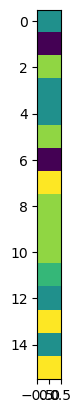

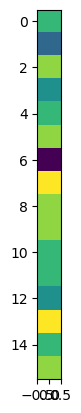

In [38]:
for step, (x, y) in enumerate(train_data):
    plt.figure()
    for (tmp_p,tmpy) in zip(x,y):
        print(">",tmp_p.shape,tmpy.shape)
        # tmp_p = input[i]

        # loss processing
        tmp_y = tf.cast(tmpy, dtype=tf.float32)
        print(tmp_y.numpy())
        plt.imshow(tmp_y)
        mask = tf.dtypes.cast(tmp_y > 0., tf.float32)
        h,w,c=mask.get_shape()
        print(mask.numpy())
        plt.imshow(mask)
        positives = tf.math.reduce_sum(mask, axis=[1,2], keepdims=True)
        negatives = h*w-positives
        print(positives.numpy())
        plt.imshow(positives)

        #beta2 = (1.*positives) / (negatives + positives) # negatives in hed
        #beta = (1.1*negatives)/ (positives + negatives) # positives in hed
        #pos_w = tf.where(tf.equal(y, 0.0), beta2, beta)
        #logits = tf.sigmoid(tmp_p)
        #print(tmp_y.shape,logits.shape)
        #l_cost = bc_loss(y_true=tmp_y, y_pred=logits,
        #                 sample_weight=pos_w)

        #preds.append(logits)

In [46]:
for step, (x, y) in enumerate(train_data):
    for tmp_p in x:
        print(">",tmp_p.shape,y.shape)
        # tmp_p = input[i]

        # loss processing
        tmp_y = tf.cast(y, dtype=tf.float32)
        mask = tf.dtypes.cast(tmp_y > 0., tf.float32)
        b,h,w,c=mask.get_shape()
        #plt.imshow(mask)
        positives = tf.math.reduce_sum(mask, axis=[1,2,3], keepdims=True)
        negatives = h*w*c-positives
        print("positives",positives.shape)
        print(positives)
        print("negatives",negatives.shape)
        print(negatives)
        beta2 = (1.*positives) / (negatives + positives) # negatives in hed
        beta = (1.1*negatives)/ (positives + negatives) # positives in hed
        pos_w = tf.where(tf.equal(y, 0.0), beta2, beta)
        logits = tf.sigmoid(tmp_p)
        #print(tmp_y.shape,logits.shape)
        #l_cost = bc_loss(y_true=tmp_y, y_pred=logits,
        #                 sample_weight=pos_w)

        #preds.append(logits)
        #loss += (l_cost*w_loss)


> (16, 16, 3) (2, 16, 16, 1)
positives (2, 1, 1, 1)
tf.Tensor(
[[[[177.]]]


 [[[174.]]]], shape=(2, 1, 1, 1), dtype=float32)
negatives (2, 1, 1, 1)
tf.Tensor(
[[[[79.]]]


 [[[82.]]]], shape=(2, 1, 1, 1), dtype=float32)
> (16, 16, 3) (2, 16, 16, 1)
positives (2, 1, 1, 1)
tf.Tensor(
[[[[177.]]]


 [[[174.]]]], shape=(2, 1, 1, 1), dtype=float32)
negatives (2, 1, 1, 1)
tf.Tensor(
[[[[79.]]]


 [[[82.]]]], shape=(2, 1, 1, 1), dtype=float32)
> (16, 16, 3) (2, 16, 16, 1)
positives (2, 1, 1, 1)
tf.Tensor(
[[[[172.]]]


 [[[176.]]]], shape=(2, 1, 1, 1), dtype=float32)
negatives (2, 1, 1, 1)
tf.Tensor(
[[[[84.]]]


 [[[80.]]]], shape=(2, 1, 1, 1), dtype=float32)
> (16, 16, 3) (2, 16, 16, 1)
positives (2, 1, 1, 1)
tf.Tensor(
[[[[172.]]]


 [[[176.]]]], shape=(2, 1, 1, 1), dtype=float32)
negatives (2, 1, 1, 1)
tf.Tensor(
[[[[84.]]]


 [[[80.]]]], shape=(2, 1, 1, 1), dtype=float32)
